Данные имеют следующую структуру:

- Записываются для каждого пользователя, совершившего покупки, каждый день
- Для каждой даты есть своя папка, внутри неё – папки для каждого пользователя
- Внутри каждой папки есть файл data.csv, где и хранятся данные

Схематично выглядит так:

└── data
   ├── 2020-12-30
   │  ├── FirstName_LastName1
   │  │   └── data.csv
   │  ├── FirstName_LastName2
   │  │   └── data.csv
   │  └── FirstName_LastName3
   │      └── data.csv
   └── 2020-12-31
      ├── FirstName_LastName1
      │   └── data.csv
      └── FirstName_LastName5
          └── data.csv
Например, 30 декабря три покупателя сделали покупки, 31 – два 
(папки 2020-12-30 и 2020-12-31 соответственно). Поскольку клиент FirstName_LastName1 купил товары в оба дня, для него имеется папка в папке для каждой из дат. Для других клиентов – по одной.

Задачи:
1. Соберите все данные из папки data в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (product_id,              quantity), а также имя пользователя (name), и дата этих покупок (date), соответствует названию папки, где лежит папка с          пользователем)

2. Выясните, какой пользователь купил больше всего товаров. Если их несколько, то перечислите имена через запятую с пробелом и в    алфавитном порядке.

3. Найдите топ-10 товаров по числу проданных единиц за всё время и постройте столбцовую диаграмму(барплот). Сколько было продано    единиц товара с product_id==56?

4. Визуализируйте продажи по дням.

5. Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым    product_id, совершенную в разные дни. 

In [2]:
# импортируем библиотке для анализа данных и более удобной работы с путем к файлам
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Задача 1

tree = os.walk("/home/jupyter-m-vosorov/shared/homeworks/python_ds_miniprojects/4/data/")
lst = [] # список, из которого впоследствии будем извлекать имя пользователя и дату
path_list = [] # список путей к каждому датасету
for i in tree: # двойной цикл чтобы пройтись по всему дереву папок и файлов
    for j in i: 
        if 'data.csv' in j: # когда находим файл с датасетом, добавляем путь к этому файлу в два заранее созданных списка
            lst.append(i[0].split()[0]) 
            path_list.append(i[0].split()[0])
for i in range(len(lst)):
    lst[i] = lst[i] + "/data.csv" 
    path_list[i] = path_list[i] + "/data.csv" 
for i in range(len(lst)):
    lst[i] = lst[i].split("/")

big_df = pd.DataFrame() # создаем пустой датафрейм к которому будет добавлять маленькие датафреймы


for i in range(len(path_list)): # пробегаемся по списку с путями к датасетам
    df = pd.read_csv(path_list[i]).drop(columns = "Unnamed: 0") # читаем датасет и убираем лишнюю колонку
    df["name"] = lst[i][9] # добавляем наполняем значениями колонку с именем
    df["date"] = lst[i][8] # добавлям и наполняем значениями колонку с датой
    big_df = pd.concat([big_df, df]) # добавляем маленький датасет к пустому, на следущей итерации он уже не будет пустым
                     
big_df.reset_index().drop(columns = "index")

# по итогу получаем объеденнённый датасет
big_df

,product_id,quantity,name,date
0,27,4,Petr_Ivanov,2020-12-05
1,89,1,Petr_Ivanov,2020-12-05
2,33,2,Petr_Ivanov,2020-12-05
3,8,3,Petr_Ivanov,2020-12-05
4,16,1,Petr_Ivanov,2020-12-05
...,...,...,...,...
0,18,4,Petr_Fedorov,2020-12-07
1,94,4,Petr_Fedorov,2020-12-07
0,95,2,Vasiliy_Ivanov,2020-12-07
1,83,3,Vasiliy_Ivanov,2020-12-07


In [4]:
# Задача 2

big_df \
    .groupby("name", as_index = False) \
    .agg({"quantity" : "sum"}) \
    .sort_values("quantity", ascending = False) \
    .head()

# Итак, больше всего покупок совершили Alexey_Smirnov и Petr_Smirnov

,name,quantity
3,Alexey_Smirnov,52
13,Petr_Smirnov,52
6,Anton_Smirnov,45
10,Petr_Fedorov,34
7,Kirill_Fedorov,28


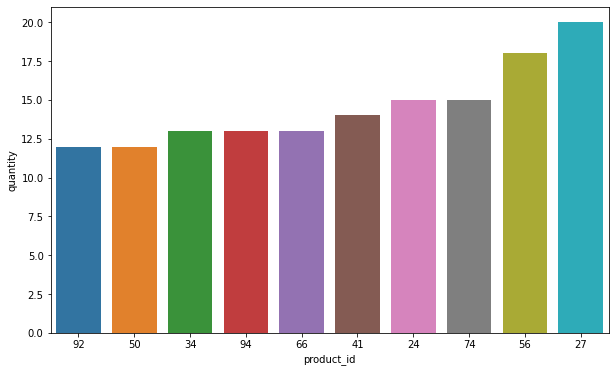

In [5]:
# Задача 3
top_ten = big_df \
            .groupby("product_id", as_index = False) \
            .agg({"quantity" : "sum"}) \
            .sort_values("quantity", ascending = False) \
            .head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x = "product_id", y = "quantity", data = top_ten, order=top_ten.sort_values('quantity').product_id)

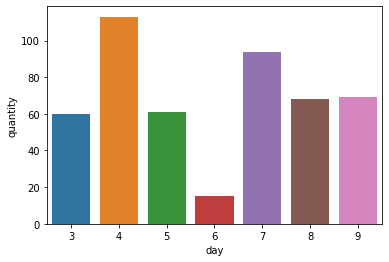

In [6]:
# Задача 4
big_df = big_df.astype({"date" : "datetime64"})
big_df['day'] = big_df["date"].dt.day
buys_per_day = big_df \
                .groupby("day", as_index = False) \
                .agg({"quantity" : "sum"}) \
                .sort_values("day", ascending = True)

sns.barplot(data = buys_per_day, x = "day", y = "quantity")

In [59]:
# Задача 5
big_df \
    .groupby(["product_id", "name"], as_index = False) \
    .agg({"date" : pd.Series.nunique}) \
    .query("date > 1") \
    .rename(columns = {"date" : "unique_dates"})
# В каждой группе будут покупики только одного пользователя и одного товара 
# И потом для каждой группы мы посчитаем сколько там уникальных дат

# Как мы видим у нас всего два пользователя покупали один и тот же товар в разные дни

,product_id,name,unique_dates
24,15,Anton_Ivanov,2
150,94,Petr_Fedorov,2
